In [ ]:
#default_exp losses.gw_test

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Giacomini-White Test

Test on out-of-sample conditional predictive ability.

References:
- Giacomini, R., & White, H. (2006). Tests of conditional predictive ability. Econometrica, 74(6), 1545-1578.
- https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2006.00718.x
- http://www.runmycode.org/companion/view/88

## Newey-West estimator

Estimator of the Newey-West Heteroskedasticity and Autocorrelation Consistent Covariance Matrix (Newey-West HAC) to calculate robust error estimations.

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats.distributions import chi2

In [ ]:
# export
def Newey_West(Z, n_lags):
    """ Newey-West HAC estimator
    Parameters
    ----------
    Z: (n, k) ndarray
    n_lags: number of lags

    Returns
    -------
    omega_hat: Newey-West HAC estimator of the covariance matrix
    """

    assert n_lags > 0

    n, k = Z.shape

    Z = Z - np.ones((n, 1)) * np.mean(Z, axis=0)
    gamma = -999 * np.ones((n_lags, k))
    omega_hat = (1/n) * np.matmul(np.transpose(Z), Z)

    Zlag = np.array([np.pad(Z, ((i,0), (0,0)), mode='constant', 
                            constant_values = 0)[:n] 
                     for i in range(1, n_lags + 1)])
    gamma = (1/n) * (np.matmul(np.transpose(Z), Zlag) + 
            np.matmul(np.einsum('ijk -> ikj', Zlag), Z))
    weights = 1 - np.array(range(1,n_lags + 1))/(n_lags + 1)
    omega_hat = omega_hat + \
                np.sum(gamma * np.expand_dims(weights, 
                                              axis = (1,2)), 
                                              axis = 0)
    return omega_hat

In [ ]:
n_lags=3
Z = np.reshape(list(range(1,101)), (20,-1))
omega_Z = Newey_West(Z=Z, n_lags=n_lags)

In [ ]:
# export
def GW_CPA_test(loss1, loss2, tau, alpha=0.05, 
                unconditional=True, verbose=True):
    """ Giacomini-White Conditional Predictive Ability Test
    Parameters
    ----------
    loss1, loss2: 1-D ndarray of length T
    tau: forecast horizon, scalar
    unconditional: boolean, True if unconditional, False if conditional
    verbose: boolean, True if prints of test are needed

    Returns
    -------
    test_stat: test statistic of the conditional predictive ability test
    crit_val: critical value of the chi-square test for a 5% confidence level
    p-val: p-value of the test
    """

    assert len(loss1) == len(loss2)

    lossdiff = loss1 - loss2
    t = len(loss1)
    instruments = np.ones_like(loss1)

    if not unconditional:
        instruments = np.hstack((instruments[:t-tau], 
                                 lossdiff[:-tau]))
        lossdiff = lossdiff[tau:]
        t = t - tau

    reg = instruments * lossdiff

    if tau == 1:

        res_beta = np.linalg.solve(reg.T.dot(reg), 
                                   reg.T.dot(np.ones((t,1))))
        err = np.ones((t,1)) - reg.dot(res_beta)
        r2 = 1 - np.mean(err**2)
        test_stat = t * r2
        q = reg.shape[1]
        crit_val = chi2.ppf(1-alpha, df=q)
        p_val = 1 - chi2.cdf(np.abs(test_stat), q)
    
    else:

        zbar = np.mean(reg, axis=0)
        n_lags = tau - 1
        omega = Newey_West(Z=reg, n_lags=n_lags)
        print(omega)
        test_stat = np.expand_dims(t*zbar, 
                                   axis=0).dot(np.linalg.inv(omega)).\
                                   dot(zbar)
        q = reg.shape[1]
        crit_val = chi2.ppf(1-alpha, df=q)
        p_val = 1 - chi2.cdf(np.abs(test_stat), q)

    av_diff_loss = np.mean(loss1-loss2)
    s = '+' if np.mean(loss1-loss2) > 0 else '-'
    
    if verbose:
        if unconditional: print('\nUnconditional test:\n')
        if not unconditional: print('\nConditional test:\n')
        print(f'Forecast horizon: {tau}, Nominal Risk Level: {alpha}')
        print(f'Test-statistic: {test_stat} ({s})')
        print(f'Critical value: {crit_val}')
        print(f'p-value: {p_val}\n')
    return test_stat, crit_val, p_val

In [ ]:
t = 10
tau = 1

loss1 = np.random.randn(10,1)
loss2 = np.random.randn(10,1)

print(f'loss1:\n{loss1}\n\nloss2:\n{loss2}')

GW_CPA_test(loss1=loss1, 
            loss2=loss2, 
            tau=tau)

GW_CPA_test(loss1=loss1, 
            loss2=loss2, 
            tau=tau, 
            unconditional=False)

loss1:
[[ 0.6971438 ]
 [-0.96489945]
 [-1.89586417]
 [ 0.49904883]
 [ 0.36498169]
 [ 1.13793146]
 [-0.03053989]
 [-1.59301423]
 [ 0.835824  ]
 [-0.09918497]]

loss2:
[[ 0.53758334]
 [ 0.64654716]
 [-2.80311586]
 [ 1.12407115]
 [ 0.66495922]
 [-1.1585949 ]
 [-1.85334736]
 [ 0.74014517]
 [ 1.7861432 ]
 [-0.10800919]]

Unconditional test:

Forecast horizon: 1, Nominal Risk Level: 0.05
Test-statistic: 0.020698469412645526 (-)
Critical value: 3.841458820694124
p-value: 0.885603420712144


Conditional test:

Forecast horizon: 1, Nominal Risk Level: 0.05
Test-statistic: 0.03291832231221514 (-)
Critical value: 5.991464547107979
p-value: 0.9836755507426486



(0.03291832231221514, 5.991464547107979, 0.9836755507426486)

In [ ]:
# export
def GW_test_p_values(y, y_hat, tau, alpha=0.05, unconditional=True):
    """ Plotting function of the GW Test p-values
    Parameters
    ----------
    y: (batch_size,) observed values
    y_hat: (k, batch_size) numpy array with predictions from k different models


    Returns
    -------
    
    """
    losses = np.abs(y - y_hat)
    k = y_hat.shape[1]
    p_values = np.zeros((k, k))

    for i in range(k):
        for j in range(k):
            if i == j: pass             
            else:
                test_stat, crit_val, p_val = \
                    GW_CPA_test(loss1=np.expand_dims(losses[:,i], axis=1),
                                loss2=np.expand_dims(losses[:,j], axis=1),
                                tau=tau, alpha=alpha, 
                                unconditional=unconditional,
                                verbose=False)
                p_values[i,j] = p_val
    
    #hm = sns.heatmap(p_values, linewidth=0.05)
    #hm.plot()

    return p_values#, hm


def plot_GW_test_p_values(y, y_hat, model_names, 
                          tau, alpha=0.05, unconditional=True, title='GW Test'):
    p_values = GW_test_p_values(y=y, y_hat=y_hat, tau=tau, 
                                alpha=0.05, unconditional=True)

    fig, ax = plt.subplots()

    #im = ax.imshow(p_values, cmap=plt.get_cmap('GnBu'), alpha=0.4)
    im = ax.imshow(p_values, cmap=plt.get_cmap('Blues_r'), alpha=0.8)
    #im = ax.imshow(p_values, cmap=plt.get_cmap('RdYlGn'), alpha=0.3)

    # Ticks and labels
    assert len(model_names) == len(p_values)
    ax.set_xticks(np.arange(len(p_values)))
    ax.set_yticks(np.arange(len(p_values)))

    ax.set_xticklabels(model_names)
    ax.set_yticklabels(model_names)

    for i in range(len(model_names)):
        text = ax.text(i, i, 'x',
                       ha="center", va="center", color="w")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, 
             ha="right", rotation_mode="anchor")

    fig.colorbar(im)

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

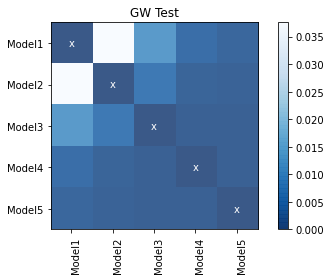

In [ ]:
y = np.random.randn(10,1)
y_hat = np.hstack([i*np.ones((10,1)) for i in range(5)])

GW_test_p_values(y=y, y_hat=y_hat, tau=tau, alpha=0.05, unconditional=True)

plot_GW_test_p_values(y=y, y_hat=y_hat, 
                      model_names=['Model1', 'Model2', 'Model3', 'Model4', 'Model5'],
                      tau=tau, alpha=0.05, unconditional=True)